# Strain assesment

Indehold:

 - Assess your predicted strain designs using simulations and pathway visualizations
 - Assess manually derived strain designs using model simulations
 - Based on your computations, provide a top 10 list of most promising cell factory designs. The criteria for "most promising" are the number of modifications, yield, growth rate and others you might define

## Quantitative strains assessment

Three different pathways; pathway 1, the manual obtained, and the combined pathway (Section 02_heterologous_pathway_implementation), were loaded. For each of them models were made containing; the model with no further modification, no NAD(+)/NADPH producing cycling (Section 05_knockout_analysis), coswap1 (Section 06_co-factor_swap), and combinations of these:

In [13]:
# Load libraries
from cobra.io import read_sbml_model
from cobra import Reaction
from cobra.core.gene import GPR
from matplotlib import pyplot as plt

In [14]:
# Making models
modelnames = {'':['p'],
              '_manual':['p'],
              '_pathway_combine':['p'],
              '_coswap1':['c',"YJL052W","YJR009C","YGR192C"],
              '_noNAD/NADPH_cycling':["k","YOR120W"]
              }

def making_KOs(model, pkc_list, new_model_name, count):
    tmp_m = model.copy()
    tmp_m.id = model.id + new_model_name
    print(f'Model {count}: {tmp_m.id}')
    count += 1
    for KO in pkc_list[1:]:
        tmp_m.genes.get_by_id(KO).knock_out()
        if tmp_m.genes.get_by_id(KO).functional != False:
            print(f"Error in knocking {tmp_m.genes.get_by_id(KO).name} out in model {tmp_m.id}!")
    return tmp_m, count


def import_reactions(model,infilename):
    with open(infilename,"r") as infile:
        infile.readline()
        for line in infile:
            line = line.rstrip().split(",")
            r = Reaction(line[0])
            r.name = line[2]
            if line[3] != "":
                r.subsystem = line[3]
            r.lower_bound = float(line[4])
            r.upper_bound = float(line[5])
            if line[1] != "":
                r.gpr = GPR.from_string(line[1])
            for i in range(int(len(line[6:])/2)):
                metaboliteID = line[6+i*2]
                if metaboliteID != "":
                    metaboliteID = m.metabolites.get_by_id(metaboliteID)
                    bin = float(line[7+i*2])
                    r.add_metabolites({metaboliteID:bin})
            model.add_reactions([r])
            try:
                model.reactions.get_by_id(r.id)
            except:
                print(f"Error in importing reaction {r} to {model.id}")


print("Making models:")
count = 1
models = {}
for model_p, pkc_id in modelnames.items():
    if pkc_id[0] == "p":
        infilename = "iMM904_progesterone"+model_p
        print(f"Model {count}: {infilename}")
        count += 1
        m_p = read_sbml_model("models/"+infilename+".xml")
        tmp_models = [m_p]
        models[model_p] = m_p
        for model_k, pkc_id in modelnames.items():
            if pkc_id[0] == "k":
                tmp_m, count = making_KOs(m_p, pkc_id, model_k, count)
                models[model_p+model_k] = tmp_m
                tmp_models.append(tmp_m)
        for m in tmp_models:
            for model_c, pkc_id in modelnames.items():
                if pkc_id[0] == "c":
                    tmp_m, count = making_KOs(m, pkc_id, model_c, count)
                    import_reactions(tmp_m, "data/co-factor_swap_reactions.csv")
                    models[m.id.split(".")[0].split("progesterone")[1] + model_c] = tmp_m



Making models:
Model 1: iMM904_progesterone
Model 2: iMM904_progesterone_noNAD/NADPH_cycling
Model 3: iMM904_progesterone_coswap1
Model 4: iMM904_progesterone_noNAD/NADPH_cycling_coswap1
Model 5: iMM904_progesterone_manual
Model 6: iMM904_progesterone_manual_noNAD/NADPH_cycling
Model 7: iMM904_progesterone_manual_coswap1
Model 8: iMM904_progesterone_manual_noNAD/NADPH_cycling_coswap1
Model 9: iMM904_progesterone_pathway_combine
Model 10: iMM904_progesterone_pathway_combine_noNAD/NADPH_cycling
Model 11: iMM904_progesterone_pathway_combine_coswap1
Model 12: iMM904_progesterone_pathway_combine_noNAD/NADPH_cycling_coswap1


The 12 obtained models were assessed on a phase plane plot:

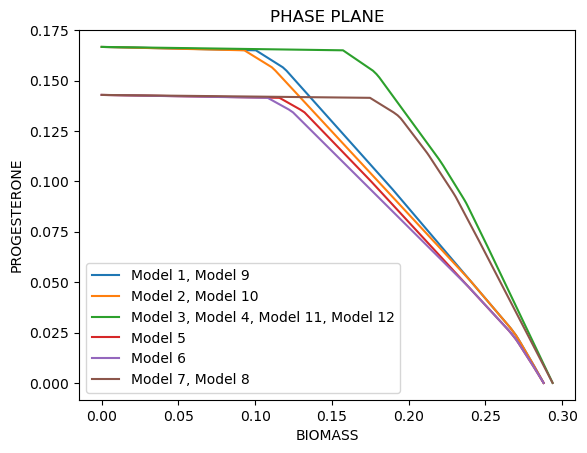

In [15]:
# Phase plane of the models
legends = []
biomass_combined = []
for j, model in enumerate(models.values()):
    with model:
        model.objective = model.reactions.DM_progesterone_c
        model.optimize()
        max_prog = model.reactions.DM_progesterone_c.flux
        model.objective = model.reactions.BIOMASS_SC5_notrace
        length = 100
        pp = []
        biomass = []
        for i in range(length):
            pp.append((i/(length-1))*max_prog)
            model.reactions.DM_progesterone_c.lower_bound = pp[i]
            biomass.append(round(model.optimize().objective_value,10))
        if biomass not in biomass_combined:
            plt.plot(biomass,pp)
            biomass_combined.append(biomass)
            legends.append("Model "+str(j+1))
        else:
            for k, bio in enumerate(biomass_combined):
                if biomass == bio:
                    legends[k] += ", Model "+str(j+1)

plt.legend(legends)
plt.xlabel("BIOMASS")
plt.ylabel("PROGESTERONE")
plt.title("PHASE PLANE")
plt.savefig('figures/08_strain_assessment_phase_plan_plot.png',bbox_inches='tight')
plt.show()

From the plot above we see that model 3, 4, 11, and 12 have the best performance. These models all have implemented the co-factor swap modification (section 06_co-factor_swap). Therefore, this modification seems to be important to get a high performing model. Interestingly, by removing NAD(+)/NADPH cycling (model 4 and 12; section 05_knockout_analysis) there are no change in the phase plane. This suggests that the co-factor swapping takes over the role that NAD(+)/NADPH cycling has. 
Models with the manually derived pathway (model 5-8) follow the same trends that for the other pathways, but with a lower maximum progesterone productivity.  

In [16]:
# printing stats of models
model_score = {}
for name, model in models.items():
    with model:
        model_score[name] = []
        model.objective = model.reactions.BIOMASS_SC5_notrace
        model.optimize()
        max_bio = model.reactions.BIOMASS_SC5_notrace.flux
        model_score[name].append(max_bio)
        model.objective = model.reactions.DM_progesterone_c
        model.optimize()
        max_prog = model.reactions.DM_progesterone_c.flux
        model_score[name].append(max_prog*(-1)/model.reactions.EX_glc__D_e.flux)
        model.objective = {model.reactions.BIOMASS_SC5_notrace: max_prog,
                           model.reactions.DM_progesterone_c: max_bio}
        model.optimize()
        model_score[name].extend([model.reactions.BIOMASS_SC5_notrace.flux,
                            model.reactions.DM_progesterone_c.flux*(-1)/model.reactions.EX_glc__D_e.flux])
        model.reactions.BIOMASS_SC5_notrace.lower_bound = 0.18
        model.objective = model.reactions.DM_progesterone_c
        model.optimize()
        model_score[name].append(model.reactions.DM_progesterone_c.flux*(-1)/model.reactions.EX_glc__D_e.flux)
print("Model number\t Max µ \t\t Max progesterone yield \t Optimized µ\t Optimized progesterone yield\t Progesterone yield at µ=0.18")
extra = "\t"
for i, values in enumerate(model_score.values()):
    if i > 8:
        extra = ""
    print(f"Model {i+1}\t"+extra,str(round(values[0],5)),"/h\t",str(round(values[1],5)),"mmol/mmol\t\t",str(round(values[2],5)),"/h\t",str(round(values[3],5)),"mmol/mmol\t\t",str(round(values[4],5)),"mmol/mmol")


Model number	 Max µ 		 Max progesterone yield 	 Optimized µ	 Optimized progesterone yield	 Progesterone yield at µ=0.18
Model 1		 0.28787 /h	 0.01667 mmol/mmol		 0.11872 /h	 0.01562 mmol/mmol		 0.01041 mmol/mmol
Model 2		 0.28787 /h	 0.01667 mmol/mmol		 0.11134 /h	 0.01563 mmol/mmol		 0.01 mmol/mmol
Model 3		 0.29373 /h	 0.01667 mmol/mmol		 0.17709 /h	 0.01547 mmol/mmol		 0.01523 mmol/mmol
Model 4		 0.29373 /h	 0.01667 mmol/mmol		 0.17709 /h	 0.01547 mmol/mmol		 0.01523 mmol/mmol
Model 5		 0.28787 /h	 0.01429 mmol/mmol		 0.13131 /h	 0.01347 mmol/mmol		 0.00963 mmol/mmol
Model 6		 0.28787 /h	 0.01429 mmol/mmol		 0.12367 /h	 0.01348 mmol/mmol		 0.00923 mmol/mmol
Model 7		 0.29373 /h	 0.01429 mmol/mmol		 0.19193 /h	 0.01333 mmol/mmol		 0.0139 mmol/mmol
Model 8		 0.29373 /h	 0.01429 mmol/mmol		 0.19193 /h	 0.01333 mmol/mmol		 0.0139 mmol/mmol
Model 9		 0.28787 /h	 0.01667 mmol/mmol		 0.11872 /h	 0.01562 mmol/mmol		 0.01041 mmol/mmol
Model 10	 0.28787 /h	 0.01667 mmol/mmol		 0.11134 /h	 0.0

In [17]:
for i, values in enumerate(model_score.values()):
    print("| Model",str(i+1),"|"," | ".join([str(round(x,4)) for x in values]),"|")

| Model 1 | 0.2879 | 0.0167 | 0.1187 | 0.0156 | 0.0104 |
| Model 2 | 0.2879 | 0.0167 | 0.1113 | 0.0156 | 0.01 |
| Model 3 | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |
| Model 4 | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |
| Model 5 | 0.2879 | 0.0143 | 0.1313 | 0.0135 | 0.0096 |
| Model 6 | 0.2879 | 0.0143 | 0.1237 | 0.0135 | 0.0092 |
| Model 7 | 0.2937 | 0.0143 | 0.1919 | 0.0133 | 0.0139 |
| Model 8 | 0.2937 | 0.0143 | 0.1919 | 0.0133 | 0.0139 |
| Model 9 | 0.2879 | 0.0167 | 0.1187 | 0.0156 | 0.0104 |
| Model 10 | 0.2879 | 0.0167 | 0.1113 | 0.0156 | 0.01 |
| Model 11 | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |
| Model 12 | 0.2937 | 0.0167 | 0.1771 | 0.0155 | 0.0152 |


In [18]:
"".join(values)

TypeError: sequence item 0: expected str instance, float found

# !!!!!!!!!!!!!!!Jeg skal ikke bruge mere herfra!!!!!!!!!!!!!

In [ ]:
# Load libraries
from dfba.plot.matplotlib import *
from dfba import DfbaModel, ExchangeFlux, KineticVariable

In [ ]:
dfba_result = {}
Vgmax = 8.5
Kg = 0.5
Vomax = 8.0
Oxy = 2
vmax_o2 = 15 
Ko = 0.024 
for name, model in models.items():
    with model:
        model.reactions.DM_progesterone_c.lower_bound = model_score[name][3]
        model.solver = "glpk"
        dfba_model = DfbaModel(model)
        X = KineticVariable("Biomass")
        Gluc = KineticVariable("Glucose")
        Pro = KineticVariable("Progesterone")
        # add kinetic variables to dfba_model
        dfba_model.add_kinetic_variables([X, Gluc, Pro])

        mu = ExchangeFlux("BIOMASS_SC5_notrace")
        v_G = ExchangeFlux("EX_glc__D_e")
        v_O = ExchangeFlux("EX_o2_e")
        v_P = ExchangeFlux("DM_progesterone_c")
        # add exchange fluxes to dfba_model
        dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

        dfba_model.add_rhs_expression("Biomass", mu * X )
        dfba_model.add_rhs_expression("Glucose", v_G * X )
        dfba_model.add_rhs_expression("Progesterone", v_P * X )
        dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)

        dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)
        dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)
        dfba_model.add_initial_conditions(
            {
                "Biomass": 0.05,
                "Glucose": 10,
                "Progesterone": 0
            }
        )
        dfba_result[name] = [dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "DM_progesterone_c"])]

In [ ]:
for name, simulation in dfba_result.items():
    plot_concentrations(simulation[0])

In [ ]:
# model.reactions.DM_progesterone_c.lower_bound = progesterone
# print(f"Setting progesterone productivity to: {progesterone} g/gDW*h")

In [ ]:
# model.solver = "glpk"
# dfba_model = DfbaModel(model)

In [ ]:
# instances of KineticVariable
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Pro = KineticVariable("Progesterone")

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Pro])

In [ ]:
model.reactions.GLYCDy

Reaction identifier,GLYCDy
Name,Glycerol dehydrogenase NADP dependent
Memory address,0x07fc4dbb18190
Stoichiometry,glyc_c + nadp_c --> dha_c + h_c + nadph_c Glycerol + Nicotinamide adenine dinucleotide phosphate --> Dihydroxyacetone + H+ + Nicotinamide adenine dinucleotide phosphate - reduced
GPR,YOR120W
Lower bound,0.0
Upper bound,999999.0


In [ ]:
model.genes.YOR120W.name

'GCY1'

In [ ]:
biomass_combined

[[0.28786570370401676,
  0.2866258169666527,
  0.28538593022928943,
  0.2841460434919261,
  0.2829061567545628,
  0.28166627001719957,
  0.28037819005186476,
  0.2790878079658674,
  0.2777974258798707,
  0.27650704379387336,
  0.275216661707876,
  0.2739262796218793,
  0.27263589753588197,
  0.2712965829965348,
  0.2698970401968212,
  0.26825563255542895,
  0.2666142249140381,
  0.26477760242842974,
  0.2628972383554952,
  0.26101687428256076,
  0.2591365102096263,
  0.25725614613669257,
  0.25537578206375805,
  0.2534954179908236,
  0.25161505391788985,
  0.24973468984495534,
  0.24785432577202088,
  0.2459739616990871,
  0.24409359762615265,
  0.24221323355321817,
  0.24033286948028368,
  0.23845250540734855,
  0.23657214133441407,
  0.2346917772614796,
  0.23281141318854515,
  0.2309310491156114,
  0.22905068504267692,
  0.22717032096974246,
  0.225289956896808,
  0.22340959282387426,
  0.22152922875093978,
  0.21964886467800532,
  0.21776850060507086,
  0.21588813653213712,
  0.214

In [ ]:
baseline_max_growth = []
baseline_max_production = []
for name, model in models.items():
    with model:
        max_growth = model.optimize().objective_value
        baseline_max_growth.append(max_growth)
        model.objective = model.reactions.DM_progesterone_c
        max_production = model.optimize().objective_value
        baseline_max_production.append(max_production)
    print(f"For model iMM904_progesterone{name}:")
    print(f"Maximum growth: {max_growth} /h")
    print(f"Maximum progesterone productivity: {max_production} mmol/gDW*h")
    print('')

For model iMM904_progesterone:
Maximum growth: 0.2878657037040168 gDW/h
Maximum progesterone productivity: 0.16666666666666666 mmol/gDW*h
For model iMM904_progesterone_KO1:
Maximum growth: 0.2878657037040168 gDW/h
Maximum progesterone productivity: 0.16666666666666666 mmol/gDW*h
For model iMM904_progesterone_coswap1:
Maximum growth: 0.29373393760455824 gDW/h
Maximum progesterone productivity: 0.16666666666666666 mmol/gDW*h
For model iMM904_progesterone_KO1_coswap1:
Maximum growth: 0.29373393760455824 gDW/h
Maximum progesterone productivity: 0.16666666666666666 mmol/gDW*h
For model iMM904_progesterone_manual:
Maximum growth: 0.287865703704016 gDW/h
Maximum progesterone productivity: 0.14285714285714285 mmol/gDW*h
For model iMM904_progesterone_manual_KO1:
Maximum growth: 0.287865703704016 gDW/h
Maximum progesterone productivity: 0.14285714285714285 mmol/gDW*h
For model iMM904_progesterone_manual_coswap1:
Maximum growth: 0.29373393760455674 gDW/h
Maximum progesterone productivity: 0.14285

In [ ]:
zymst = models[""].metabolites.zymst_c

In [ ]:
fluxes = models[""].optimize().fluxes

In [ ]:
for reac in zymst.reactions:
    print(reac)

R07498: h_c + nadph_c + zymst_c <=> cholesta8en3betaol_c + nadp_c
CHLSTI: amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c
ZYMSTESTH_SC: h2o_c + 0.01 zymstest_SC_c --> h_c + 0.02 hdca_c + 0.655 hdcea_c + 0.01 hexc_c + 0.03 ocdca_c + 0.27 ocdcea_c + 0.015 ttdca_c + 0.01 zymst_c
ZYMSTAT_SC: 0.655 hdcoa_c + 0.01 hexccoa_c + 0.27 odecoa_c + 0.02 pmtcoa_c + 0.03 stcoa_c + 0.015 tdcoa_c + 0.01 zymst_c --> coa_c + 0.01 zymstest_SC_c
ZYMSTt: zymst_e <=> zymst_c
BIOMASS_SC5_notrace: 1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024 dgmp_c + 0.0036 dtmp_c + 0.0007 ergst_c + 0.1054 gln__L_c + 0.3018 glu__L_c + 0.2904 gly_c + 0.5185 glycogen_c + 0.046 gmp_c + 59.276 h2o_c + 0.0663 his__L_c + 0.1927 ile__L_c + 0.2964 leu__L_c + 0.2862 lys__L_c + 0.8079 mannan_c + 0.0507 met__L_c + 6e-06 pa_SC_c + 6e-05 pc_SC_c + 4.5e-05 pe_SC_c + 0.1339 ph

In [ ]:
legends = []
for i in range(len(models.keys())):
    legends.append("Model "+str(i+1))
print(legends)

In [ ]:
models[""].reactions.C3STKR2

Reaction identifier,C3STKR2
Name,C 3 sterol keto reductase zymosterol
Memory address,0x07fc42aae79a0
Stoichiometry,h_c + nadph_c + zym_int2_c --> nadp_c + zymst_c H+ + Nicotinamide adenine dinucleotide phosphate - reduced + Zymosterol intermediate 2 C27H42O --> Nicotinamide adenine dinucleotide phosphate + Zymosterol C27H44O
GPR,YLR100W
Lower bound,0.0
Upper bound,999999.0


In [ ]:
print("BIOMASS:",models[''].optimize().fluxes["BIOMASS_SC5_notrace"]*0.0015*10000)
for reac in zymst.reactions:
    print(reac.id, models[''].optimize().fluxes[reac.id]*10000,"|",reac.reaction)

BIO: 4.31798555556026
R07498 0.0 | h_c + nadph_c + zymst_c <=> cholesta8en3betaol_c + nadp_c
CHLSTI 2.015059925928121 | amet_c + o2_c + zymst_c --> ahcys_c + ergtetrol_c + 2.0 h2o_c + h_c
ZYMSTESTH_SC 0.0 | h2o_c + 0.01 zymstest_SC_c --> h_c + 0.02 hdca_c + 0.655 hdcea_c + 0.01 hexc_c + 0.03 ocdca_c + 0.27 ocdcea_c + 0.015 ttdca_c + 0.01 zymst_c
ZYMSTAT_SC 0.0 | 0.655 hdcoa_c + 0.01 hexccoa_c + 0.27 odecoa_c + 0.02 pmtcoa_c + 0.03 stcoa_c + 0.015 tdcoa_c + 0.01 zymst_c --> coa_c + 0.01 zymstest_SC_c
ZYMSTt 0.0 | zymst_e <=> zymst_c
BIOMASS_SC5_notrace 2878.6570370401732 | 1.1348 13BDglcn_c + 0.4588 ala__L_c + 0.046 amp_c + 0.1607 arg__L_c + 0.1017 asn__L_c + 0.2975 asp__L_c + 59.276 atp_c + 0.0447 cmp_c + 0.0066 cys__L_c + 0.0036 damp_c + 0.0024 dcmp_c + 0.0024 dgmp_c + 0.0036 dtmp_c + 0.0007 ergst_c + 0.1054 gln__L_c + 0.3018 glu__L_c + 0.2904 gly_c + 0.5185 glycogen_c + 0.046 gmp_c + 59.276 h2o_c + 0.0663 his__L_c + 0.1927 ile__L_c + 0.2964 leu__L_c + 0.2862 lys__L_c + 0.8079 mannan_

In [ ]:
# with model: 
#     Glucose_exchange = model.reactions.get_by_id('EX_glc__D_e') #define glucose reaction
#     medium = model.medium
#     model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): baseline_max_production, 
#                     model.reactions.get_by_id('DM_progesterone_c'): baseline_max_growth} # objective is to lead flux through the reaction producing progesterone top maximise production
#     solution = model.optimize()
#     progesterone_production = solution.fluxes['DM_progesterone_c']
#     glucose_flux = model.reactions.EX_glc__D_e.flux
#     max_yield = progesterone_production/(-1 * glucose_flux)
#     print('Glucose concentration: ',format(medium[Glucose_exchange.id]))
#     print('Maximum theoretical biomass productivity: ', round(solution.fluxes['BIOMASS_SC5_notrace'],5), 'gDW/h')
#     print('Maximum theoretical productivity of progesterone on glucose: ', round(progesterone_production,5), 'mmol/gDW*h') # calculate productivity
#     print('Maximum theoretical yield of progesterone on glucose: ', round(max_yield,5), 'mmol progesterone/mmol glucose') # calculate yield on galactose

In [ ]:
kage = models[""].copy()
# kage.reactions.G3PD1ir.lower_bound = 1
flux = kage.optimize().fluxes
kage.reactions.G3PD1ir

print(kage.objective)
baseline_max_growth = kage.optimize().objective_value
# model.objective = model.reactions.DM_progesterone_c



print("Flux before",flux["G3PD1ir"])
print("BIOMASS",flux["BIOMASS_SC5_notrace"])
print("Flux zymst",flux["C3STKR2"])
with kage as k:
    k.objective = k.reactions.DM_progesterone_c
    baseline_max_production = k.optimize().objective_value
    flux_efter = kage.optimize().fluxes
    print("efter",flux_efter["G3PD1ir"])

Maximize
1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
før 0.007110282881489255
BIO 0.28786570370401837
zymst 0.0006333045481488405
efter 7.37037037037036


In [ ]:
with kage as model: 


    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): 1, 
                    model.reactions.get_by_id('DM_progesterone_c'): 1} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    progesterone_production = solution.fluxes['DM_progesterone_c']
    glucose_flux = model.reactions.EX_glc__D_e.flux
    max_yield = progesterone_production/(-1 * glucose_flux)
    # print('Glucose concentration: ',format(medium[Glucose_exchange.id]))
    print('Maximum growth:', round(solution.fluxes['BIOMASS_SC5_notrace'],3), '/h')
    print('Maximum progesterone productivity:', round(progesterone_production,3), 'mmol/gDW*h') # calculate productivity
    print('Maximum progesterone yield:', round(max_yield,3), 'mmol progesterone/mmol glucose') # calculate yield on galactose
    print('')
    

Maximum theoretical biomass productivity:  0.26631 gDW/h
Maximum theoretical productivity of progesterone on glucose:  0.02724 mmol/gDW*h
Maximum theoretical yield of progesterone on glucose:  0.00272 mmol progesterone/mmol glucose


In [ ]:
with kage as model: 
    kage.reactions.G3PD1ir.lower_bound = 4

    model.objective = {model.reactions.get_by_id('BIOMASS_SC5_notrace'): 1, 
                    model.reactions.get_by_id('DM_progesterone_c'): 1} # objective is to lead flux through the reaction producing progesterone top maximise production
    solution = model.optimize()
    progesterone_production = solution.fluxes['DM_progesterone_c']
    glucose_flux = model.reactions.EX_glc__D_e.flux
    max_yield = progesterone_production/(-1 * glucose_flux)
    # print('Glucose concentration: ',format(medium[Glucose_exchange.id]))
    print('Maximum growth:', round(solution.fluxes['BIOMASS_SC5_notrace'],3), '/h')
    print('Maximum progesterone productivity:', round(progesterone_production,3), 'mmol/gDW*h') # calculate productivity
    print('Maximum progesterone yield:', round(max_yield,3), 'mmol progesterone/mmol glucose') # calculate yield on galactose
    print('')

Maximum theoretical biomass productivity:  0.24241 gDW/h
Maximum theoretical productivity of progesterone on glucose:  0.04822 mmol/gDW*h
Maximum theoretical yield of progesterone on glucose:  0.00482 mmol progesterone/mmol glucose


In [ ]:
kage.reactions.ME2m.upper_bound = 0
flux = kage.optimize().fluxes
kage.reactions.ME2m
print("Flux before",flux["ME2m"])
print("BIOMASS",flux["BIOMASS_SC5_notrace"])
print("Flux zymst",flux["C3STKR2"])


før 0.0
BIO 0.28014440931761936
zymst 0.0006163177004987626


In [ ]:
mmmm.metabolites

In [ ]:
print(mmmm.reactions.GAPD)
mmmm.reactions.GAPD.id

GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c


'GAPD'

In [ ]:
# Recreates KOs on models with KOs
model_KOs = {models[0]:["YJL052W","YJR009C","YGR192C"],
             models[0]:["YJL052W","YJR009C","YGR192C"],
             models[0]:["YJL052W","YJR009C","YGR192C"]}

for m, KOs in model_KOs.items():
    print(f"For model {m.id}:")
    for KO in KOs:
        m.genes.get_by_id(KO).knock_out()
        if m.genes.get_by_id(KO).functional == False:
            print(f"{m.genes.get_by_id(KO).name} were successfully knocked out")  
        else:
            print(f"Error in knocking {m.genes.get_by_id(KO).name} out!")

## Metabolic pathway visualisations using Escher

The addition or deletion of genes, e.g., when implementing a heterologous pathway, will change the normal flux balances. Online programs like Escher can be used for visualisation of these changes.

### Visualised fluxes on central carbon metabolism map

In [ ]:
# Load relevant packages
from IPython.display import Image
import escher
import pandas
import cobra

In [ ]:
escher.list_available_maps() # see available maps in escher

It can be seen that the only available map for *Saccharomyces cerevisiae* is the iMM904 central carbon metabolism. When implementing out heterologous pathway, the normally occuring fluxes are altered; The alterations on the central carbon metabolism can be visulased using Escher on the available map in *S. cerevisiae*.

In [ ]:
model = read_sbml_model('models/iMM904_progesterone.xml') # Load model
model.objective = model.reactions.R02216 
solution = model.optimize() # simulate model
fluxes = solution.fluxes

In [ ]:
escher.Builder('iMM904.Central carbon metabolism',
               reaction_data=fluxes.to_dict()) # Adding our fluxes to the iMM904 model and watch how they change - the map is saved as a figure 

### Visualisation of heterologous pathway and fluxes

In [ ]:
model = read_sbml_model('models/iMM904_progesterone.xml') # Load model
model.objective = model.reactions.R02216 # set objective to progesterone production
solution = model.optimize() # simulate model
fluxes = solution.fluxes.to_csv("flux.csv") # save simulated fluxes as csv file that can be uploaded to the online version of escher